# Fourier transform

In [1]:
using Revise
using Plots
using LinearAlgebra
using SparseIR
import SparseIR: valueim

newaxis = [CartesianIndex()]

1-element Vector{CartesianIndex{0}}:
 CartesianIndex()

In [2]:
BLAS.set_num_threads(16)

In [3]:
println(Threads.nthreads())

1


In [4]:
using ITensors

println(ITensors.blas_get_num_threads())

16


We want create a MPO for Fourier transform:
$$
F(t) = \sum_{x=0}^{N-1} f(x) e^{-i \frac{2\pi t x}{N}} = \sum_{x=0}^{N-1} T(t, x) f(x).
$$

MPS/MPO tensors are indexed from the left to the right in ascending order.
We assign the least significant digit to the first or the last tensor.
Let us stick to the former convention.

$x=0,...., 2^Q-1$ can be represented as a binary number, $0b001, 0b010, ..., 0b111 (=0b x_{Q-1} x_{Q-2} ... x_0)$ for $Q=3$.

$$
F(t_0, \cdots, t_{Q-1}) = \sum_{x_0=0}^1 \cdots \sum_{x_{Q-1}=0}^1  T(t_0, \cdots, t_{Q-1}, x_0, \cdots, x_{Q-1}) f(x_0, \cdots, x_{Q-1}).
$$

We transpose the tensor $T$ as $\bar T$:

$$
\bar T(t_Q, x_0, \cdots, t_0, x_{Q-1}) = T(t_0, \cdots, T_{Q-1}, x_0, \cdots, x_{Q-1})
$$

In MPS/MPO, states[1] corresponds to $x_0$ and $t_{Q-1}$ (long-range and high frequency).

In [6]:
nbit = 4
N = 2^nbit

sites = siteinds("Qubit", nbit)
sitesT = reverse(sites)

tmat = zeros(ComplexF64, N, N)

for t in 0:N-1, x in 0:N-1
    tmat[t+1, x+1] = exp(-im * 2π * t * x/N)
end
#@show tmat

tmat = reshape(tmat, ntuple(x->2, 2*nbit))
# At point, the indices of `tmat` is (t_0, ..., t_{Q-1}, x_0, ..., x_{Q-1})
;

dims = [4, 5, 3, 6, 2, 7, 1, 8]


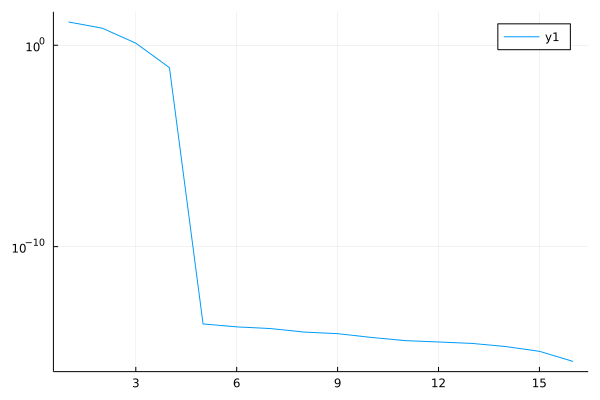

In [7]:
let
    # `tmat:` (t_0, ..., t_{Q-1}, x_0, ..., x_{Q-1})
    # `tensor`: (t_{Q-1}, x0, ..., t0, x_{Q-1})
    # x_0 and t_{Q-1} must be paired because they correspond to the same small length scale in the $x$ space.
    # Otherwise, the bod dimension will be exponentially huge.
    dims = Int[]
    for i in 1:nbit
        push!(dims, nbit+1-i)
        push!(dims, i+nbit)
    end
    @show dims

    tensor = permutedims(tmat, dims)

    svd_res = svd(reshape(tensor, N, N))
    plot(svd_res.S, yaxis=:log)
end

In [8]:
# `tmat:` (t_0, ..., t_{Q-1}, x_0, ..., x_{Q-1})
# `tensor2`: (t_{Q-1}, ..., t0, x_0, ..., x_{Q-1})
dims = Int[]
for i in 1:nbit
    push!(dims, nbit+1-i)
end
for i in 1:nbit
    push!(dims, i+nbit)
end
@show dims

cutoff = 1E-10
maxdim = 100

tensor2 = permutedims(tmat, dims)

M = MPO(ITensor(tensor2, sites, sites'), sites; cutoff=cutoff, maxdim=maxdim)

dims = [4, 3, 2, 1, 5, 6, 7, 8]


MPO
[1] ((dim=2|id=618|"Qubit,Site,n=1"), (dim=2|id=618|"Qubit,Site,n=1")', (dim=2|id=568|"Link,n=1"))
[2] ((dim=2|id=568|"Link,n=1"), (dim=2|id=743|"Qubit,Site,n=2"), (dim=2|id=743|"Qubit,Site,n=2")', (dim=4|id=573|"Link,n=2"))
[3] ((dim=4|id=573|"Link,n=2"), (dim=2|id=994|"Qubit,Site,n=3"), (dim=2|id=994|"Qubit,Site,n=3")', (dim=2|id=50|"Link,n=3"))
[4] ((dim=2|id=50|"Link,n=3"), (dim=2|id=841|"Qubit,Site,n=4"), (dim=2|id=841|"Qubit,Site,n=4")')


In [9]:
for states in [repeat(["1"], nbit)]
    psix = MPS(sites, states)
    psiy = noprime(contract(M, psix))

    # Indices of psiy: (t_{Q-1}, ...., t_0)
    psiy_arr = Array(reduce(*, psiy), sites...)
    #@assert psiy_arr ≈ ones(ComplexF64, size(psiy_arr)...)

    # Indices of psix: (x_0, ...., x_{Q-1})
    vecx = reshape(Array(reduce(*, psix), sites...), N)
    @show vec(psiy_arr)
    @show reshape(tensor2, N, N) * vecx
end

vec(psiy_arr) = ComplexF64[0.9999999999999987 + 3.2433337799755523e-15im, 0.9238795325112874 + 0.38268343236508384im, 0.7071067811865472 + 0.7071067811865396im, 0.38268343236509583 + 0.9238795325112906im, -4.732024719885191e-15 + 0.9999999999999974im, -0.3826834323650851 + 0.9238795325112878im, -0.7071067811865407 + 0.7071067811865461im, -0.9238795325112917 + 0.3826834323650953im, -0.999999999999999 - 4.0694313210604185e-15im, -0.9238795325112873 - 0.3826834323650848im, -0.707106781186547 - 0.7071067811865405im, -0.38268343236509517 - 0.9238795325112913im, 5.4069068067815776e-15 - 1.0000000000000004im, 0.3826834323650857 - 0.9238795325112849im, 0.7071067811865416 - 0.7071067811865455im, 0.9238795325112924 - 0.3826834323650943im]
reshape(tensor2, N, N) * vecx = 

ComplexF64[1.0 + 0.0im, -1.0 - 5.3896838775215305e-15im, -2.6948419387607653e-15 + 1.0im, 9.790984586812941e-16 - 1.0im, 0.7071067811865466 + 0.7071067811865485im, -0.7071067811865454 - 0.7071067811865498im, -0.7071067811865479 + 0.7071067811865471im, 0.7071067811865467 - 0.7071067811865483im, 0.9238795325112865 + 0.3826834323650904im, -0.9238795325112851 - 0.3826834323650937im, -0.3826834323650912 + 0.9238795325112862im, 0.38268343236508306 - 0.9238795325112895im, 0.38268343236508956 + 0.9238795325112868im, -0.3826834323650813 - 0.9238795325112903im, -0.9238795325112865 + 0.38268343236509034im, 0.9238795325112886 - 0.38268343236508534im]


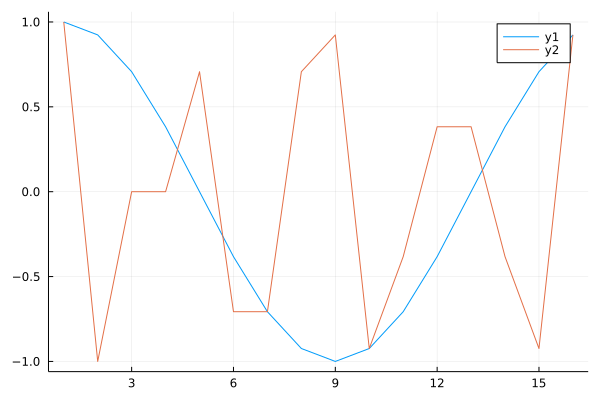

In [10]:
states = repeat(["1"], nbit)
psix = MPS(sites, states)
psiy = noprime(contract(M, psix))

# Indices of psiy: (t_{Q-1}, ...., t_0)
psiy_arr = Array(reduce(*, psiy), sites...)
#@assert psiy_arr ≈ ones(ComplexF64, size(psiy_arr)...)

# Indices of psix: (x_0, ...., x_{Q-1})
vecx = reshape(Array(reduce(*, psix), sites...), N)

p = plot()
plot!(p, real.(vec(psiy_arr)))


tmp = reshape(tensor2, N, N) * vecx
plot!(p, real.(vec(tmp)))